In [1]:
### PACKAGES

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Audio
import pickle as pkl
from scipy.signal import resample

In [2]:
### FUNCTIONS

from src.model.pipeline_waveunet import PipelineWaveUnet
from src.libs.evaluation import eval_signal
from src.libs.preprocessing import from_numpy_to_torch, from_torch_to_numpy

In [3]:
### CONSTANTS

SAMPLING_FREQUENCY = 8000
ID_EXPERIMENT = 201
pipeline_path = f"output/waveunet_{ID_EXPERIMENT}/training/pipeline.pkl"
train_loss_path = f"output/waveunet_{ID_EXPERIMENT}/training/train_loss.npy"
valid_loss_path = f"output/waveunet_{ID_EXPERIMENT}/training/valid_loss.npy"
array_noised_path = f"output/waveunet_{ID_EXPERIMENT}/testing/array_noised.npy"
array_original_path = f"output/waveunet_{ID_EXPERIMENT}/testing/array_original.npy"
array_denoised_path = f"output/waveunet_{ID_EXPERIMENT}/testing/array_denoised.npy"

In [4]:
### LOAD MODEL AND LOSSES

with open(pipeline_path, "rb") as file:
    pipeline = pkl.load(file)
train_loss = np.load(train_loss_path)
valid_loss = np.load(valid_loss_path)

In [8]:
total_params = sum(p.numel() for p in pipeline.model.parameters())
total_params


2204690

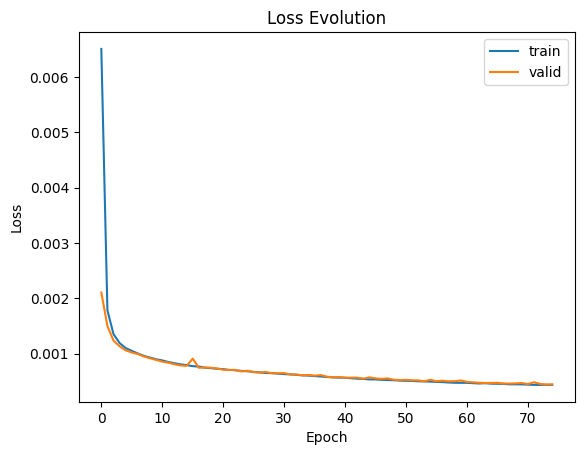

In [6]:
### PLOT LOSS EVOLUTION

plt.plot(train_loss, label="train")
plt.plot(valid_loss, label="valid")
plt.title("Loss Evolution")
plt.xlabel("Epoch")
plt.xticks([i for i in range(train_loss.shape[0]) if i % 10 == 0])
plt.ylabel("Loss")
plt.legend()
plt.show()

In [7]:
### LOAD DATA

array_noised = np.load(array_noised_path)
array_original = np.load(array_original_path)
array_denoised = np.load(array_denoised_path)

In [20]:
### CHOOSE A SIGNAL

ID_SIGNAL = 100

noised_signal = array_noised[ID_SIGNAL, :]
original_signal = array_original[ID_SIGNAL, :]
predicted_signal = array_denoised[ID_SIGNAL, :]

In [21]:
### RESAMPLE FOR FS=8000Hz


def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    return resample(signal, num_samples)


noised_resampled = resample_signal(noised_signal, SAMPLING_FREQUENCY, 8000)
original_resampled = resample_signal(original_signal, SAMPLING_FREQUENCY, 8000)
predicted_resampled = resample_signal(predicted_signal, SAMPLING_FREQUENCY, 8000)

In [22]:
print(f"Noised shape : {noised_resampled.shape}")
print(f"Original shape : {original_resampled.shape}")
print(f"Predicted shape : {predicted_resampled.shape}")

Noised shape : (80000,)
Original shape : (80000,)
Predicted shape : (80000,)


## **AUDIO COMPARISON**

In [17]:
### NOISED

# Audio(noised_signal, rate=SAMPLING_FREQUENCY)
Audio(noised_resampled, rate=8000)

In [18]:
### ORIGINAL


# Audio(original_signal, rate=SAMPLING_FREQUENCY)
Audio(original_resampled, rate=8000)

In [19]:
### PREDICTED


# Audio(predicted_signal, rate=SAMPLING_FREQUENCY)
Audio(predicted_resampled, rate=8000)

## **SIGNAL COMPARISON**

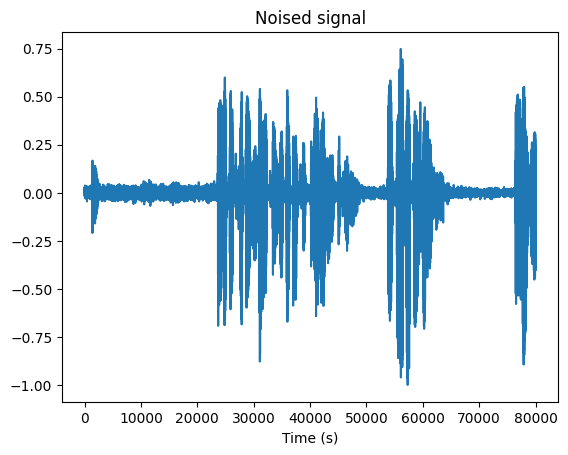

In [23]:
### NOISED

plt.plot(noised_resampled)
plt.xlabel("Time (s)")
plt.title("Noised signal")
plt.show()

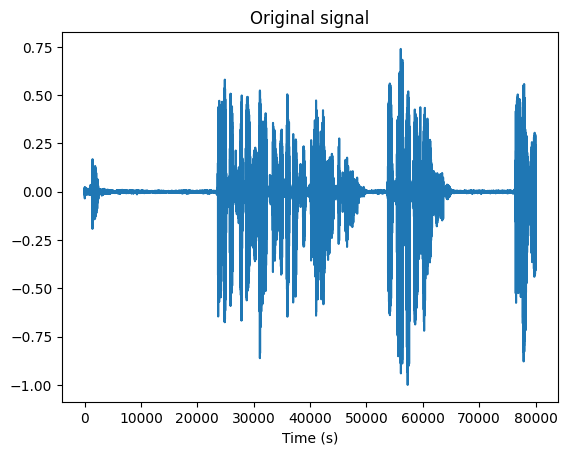

In [24]:
### ORIGINAL

plt.plot(original_resampled)
plt.xlabel("Time (s)")
plt.title("Original signal")
plt.show()

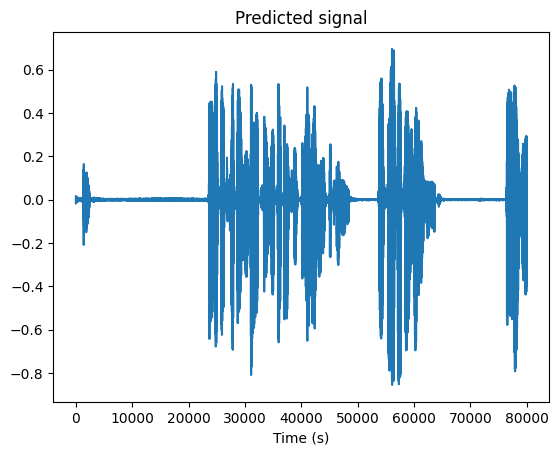

In [25]:
### PREDICTED

plt.plot(predicted_resampled)
plt.xlabel("Time (s)")
plt.title("Predicted signal")
plt.show()

## **METRICS**

In [26]:
### ALL METRICS

mse, rmse, snr, stoi_result, pesq_result = eval_signal(
    signal_pred=predicted_resampled,
    signal_target=original_resampled,
    f_sampling=8000,
)

print(f"MSE : {mse}")
print(f"RMSE : {rmse}")
print(f"SNR : {snr}")
print(f"STOI : {stoi_result}")
print(f"PESQ : {pesq_result}")

MSE : 8.436125062871724e-05
RMSE : 0.009184838272631168
SNR : 21.65410041809082
STOI : 0.9371964879787049
PESQ : 3.634657144546509


## **METRICS FOR ALL SIGNALS**

In [40]:
n = array_original.shape[0]

mse_sum = np.zeros(n)
rmse_sum = np.zeros(n)
snr_sum = np.zeros(n)
stoi_sum = np.zeros(n)
pesq_sum = np.zeros(n)

for i in tqdm(range(n)):
    noised_signal = array_noised[i, :]
    original_signal = array_original[i, :]
    predicted_signal = array_denoised[i, :]
    mse, rmse, snr, stoi_result, pesq_result = eval_signal(
        signal_pred=predicted_signal,
        signal_target=original_signal,
        f_sampling=8000,
    )
    mse_sum[i] = mse
    rmse_sum[i] = rmse
    snr_sum[i] = snr
    stoi_sum[i] = stoi_result
    pesq_sum[i] = pesq_result

print(f"MSE (average): {mse_sum.mean()},")
print(f"RMSE (average): {rmse_sum.mean()}")
print(f"SNR (average): {snr_sum.mean()}")
print(f"STOI (average): {stoi_sum.mean()}")
print(f"PESQ (average): {pesq_sum.mean()}")

100%|██████████| 782/782 [02:36<00:00,  5.01it/s]

MSE (average): 0.0004377228904982506,
RMSE (average): 0.01838691571496351
SNR (average): 17.788286762164375
STOI (average): 0.9281481335715683
PESQ (average): 2.82842263815653
